## 1

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
from tqdm import tqdm
import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
driver = webdriver.Chrome()
news_title = []

url = "https://www.marketwatch.com/investing/stock/tsla?mod=search_symbol"
driver.get(url)

driver.maximize_window()
time.sleep(2)
driver.execute_script("window.scrollTo(0, 750);")

itemlist = driver.find_element_by_class_name('collection.collection--moreHeadlines.j-scrollViewport.lazyloaded')

n = 450
tsla_titles = []
while True:
    headlines = driver.find_elements_by_class_name('article__headline')
    for headline in headlines:
        title = headline.text
        if title not in tsla_titles:
            tsla_titles.append(title)
    driver.execute_script("arguments[0].scrollBy(0, 1000)", itemlist)
    time.sleep(2)
    if len(tsla_titles) > n:
        tsla_titles = tsla_titles[:n]
        break
driver.close()

In [ ]:
n = 450
driver = webdriver.Chrome()
news_title = []

url = "https://www.marketwatch.com/investing/stock/googl?mod=search_symbol"
driver.get(url)

driver.maximize_window()
time.sleep(2)
driver.execute_script("window.scrollTo(0, 750);")

itemlist = driver.find_element_by_class_name('collection.collection--moreHeadlines.j-scrollViewport.lazyloaded')

google_titles = []
while True:
    headlines = driver.find_elements_by_class_name('article__headline')
    for headline in headlines:
        title = headline.text
        if title not in google_titles:
            google_titles.append(title)
    driver.execute_script("arguments[0].scrollBy(0, 1000)", itemlist)
    time.sleep(2)
    if len(google_titles) > n:
        google_titles = google_titles[:n]
        break
driver.close()

In [ ]:
title_df = pd.DataFrame({'TSLA':tsla_titles, 'GOOGL':google_titles})
title_df.head()

In [ ]:
title_df.to_csv('titles.csv')

In [3]:
title_df = pd.read_csv('titles.csv', index_col=0)
title_df.head()

,TSLA,GOOGL
0,AUTOS These 2 EV Stocks Look Like Buys. Why Te...,WARREN BUFFETT How Warren Buffett Could Preven...
1,AUTOS Tesla Gets Good News From China. Stock I...,‘It was not sustainable or real’: Tech layoffs...
2,Elon Musk’s Twitter ‘involvement’ was bad for ...,Deepfake ad of Mark Zuckerberg praises Congres...
3,AUTOS XPeng’s Results Miss Forecasts but Guida...,Alphabet stock price target cut to $135 from $...
4,Competitors chip away at Tesla’s share of U.S....,Alphabet Inc. Cl A stock underperforms Tuesday...


In [4]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [5]:
normalized_text_tsla = []
normalized_text_google = []
for i in range(title_df.shape[0]):
    tsla_temp, google_temp = title_df['TSLA'][i], title_df['GOOGL'][i]
    tsla_token = re.sub(r"[^a-z0-9]+", " ", tsla_temp.lower())
    google_token = re.sub(r"[^a-z0-9]+", " ", google_temp.lower())
    tsla_token = word_tokenize(tsla_token)
    google_token = word_tokenize(google_token)
    result_tsla, result_google = [], []
    for word in tsla_token:
        if word not in stop_words:
            result_tsla.append(word)
    for word in google_token:
        if word not in stop_words:
            result_google.append(word)
    normalized_text_tsla.append(result_tsla)
    normalized_text_google.append(result_google)

In [6]:
sentence_length_tsla = np.array([len(sentence) for sentence in normalized_text_tsla])
sentence_length_google = np.array([len(sentence) for sentence in normalized_text_google])

print("Avg length of sentence(TSLA): ", sentence_length_tsla.mean())
print("Avg length of sentence(Google): ", sentence_length_google.mean())

Avg length of sentence(TSLA):  9.104444444444445
Avg length of sentence(Google):  9.051111111111112


In [7]:
model_tsla = Word2Vec(sentences=normalized_text_tsla, size=20, window=5,
                min_count=5)
model_google = Word2Vec(sentences=normalized_text_google, size=20, window=5,
                min_count=5)

In [8]:
print("car")
print(model_tsla.wv.most_similar('car'))

print("google")
print(model_google.wv.most_similar('google'))

car
[('sales', 0.6289829015731812), ('rise', 0.5264872312545776), ('stock', 0.517425537109375), ('breaking', 0.4811105728149414), ('market', 0.4661098122596741), ('falling', 0.45710763335227966), ('would', 0.44918447732925415), ('deliveries', 0.4489373564720154), ('companies', 0.4391603469848633), ('cryptocurrencies', 0.4067395329475403)]
google
[('inflation', 0.6641948819160461), ('consumer', 0.6345851421356201), ('lawsuit', 0.5325157046318054), ('price', 0.525513768196106), ('1', 0.5224100947380066), ('expected', 0.4872860610485077), ('look', 0.4621416926383972), ('world', 0.43121832609176636), ('lost', 0.4293917417526245), ('rises', 0.42013686895370483)]


In [9]:
tsla_word_vectors, google_word_vectors = model_tsla.wv, model_google.wv
tsla_vocabs, google_vocabs = tsla_word_vectors.vocab.keys(), google_word_vectors.vocab.keys()
print("# of vocabs(TSLA): ", len(tsla_vocabs))
print("# of vocabs(GOOGL): ", len(google_vocabs))

tsla_vectors_list = [tsla_word_vectors[i] for i in tsla_vocabs]
google_vectors_list = [google_word_vectors[j] for j in google_vocabs]

# of vocabs(TSLA):  145
# of vocabs(GOOGL):  152


In [10]:
tsla_model = TSNE(n_components=2)
tsla_tsne = tsla_model.fit_transform(tsla_vectors_list)

google_model = TSNE(n_components=2)
google_tsne = google_model.fit_transform(google_vectors_list)

In [11]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(25,15))
    plt.scatter(xs,ys, marker='o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))  

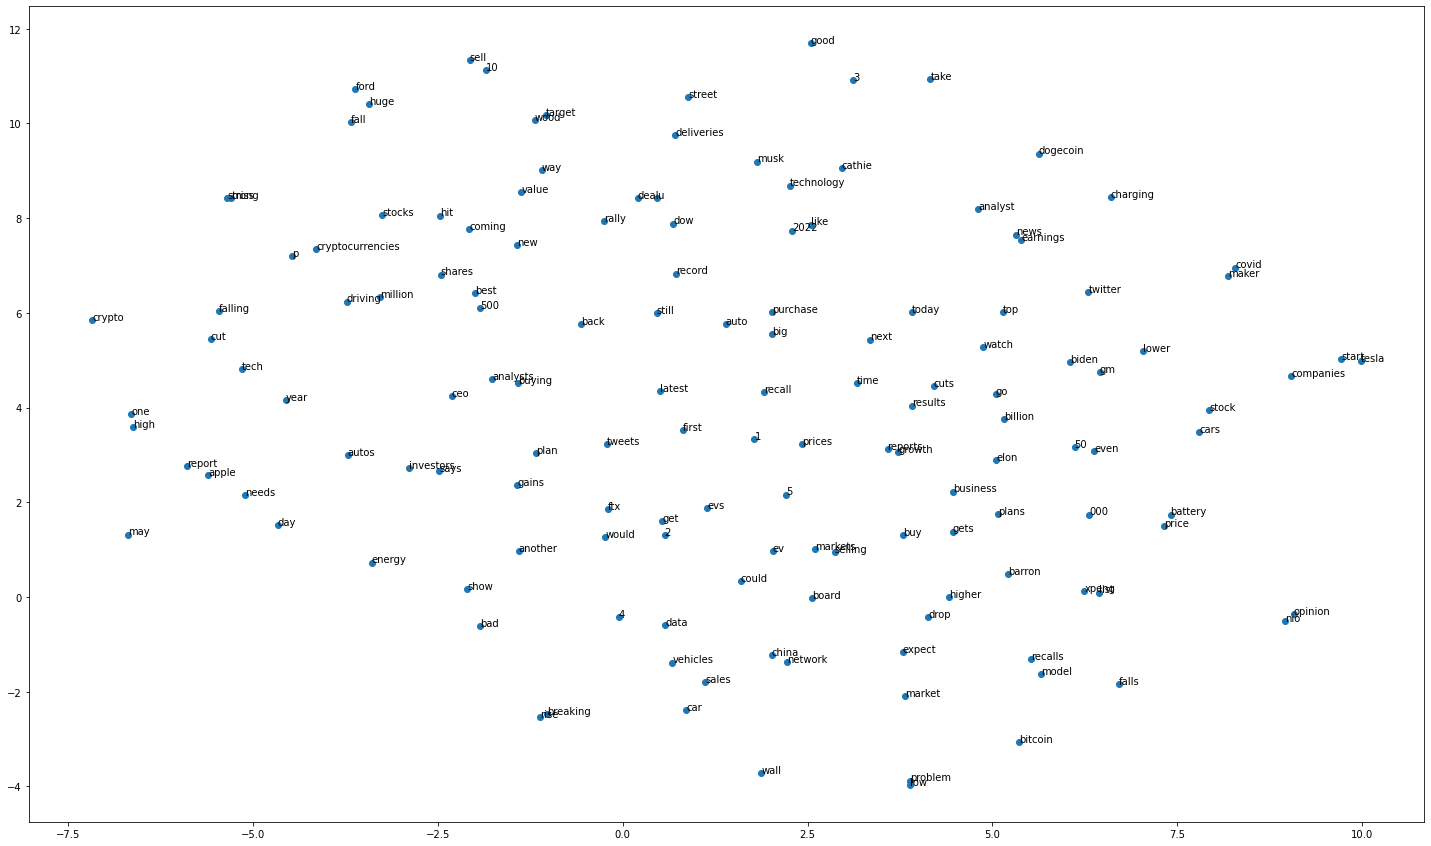

In [12]:
# TSLA graph
xs,ys = tsla_tsne[:,0], tsla_tsne[:,1]
plot_2d_graph(tsla_vocabs, xs, ys)

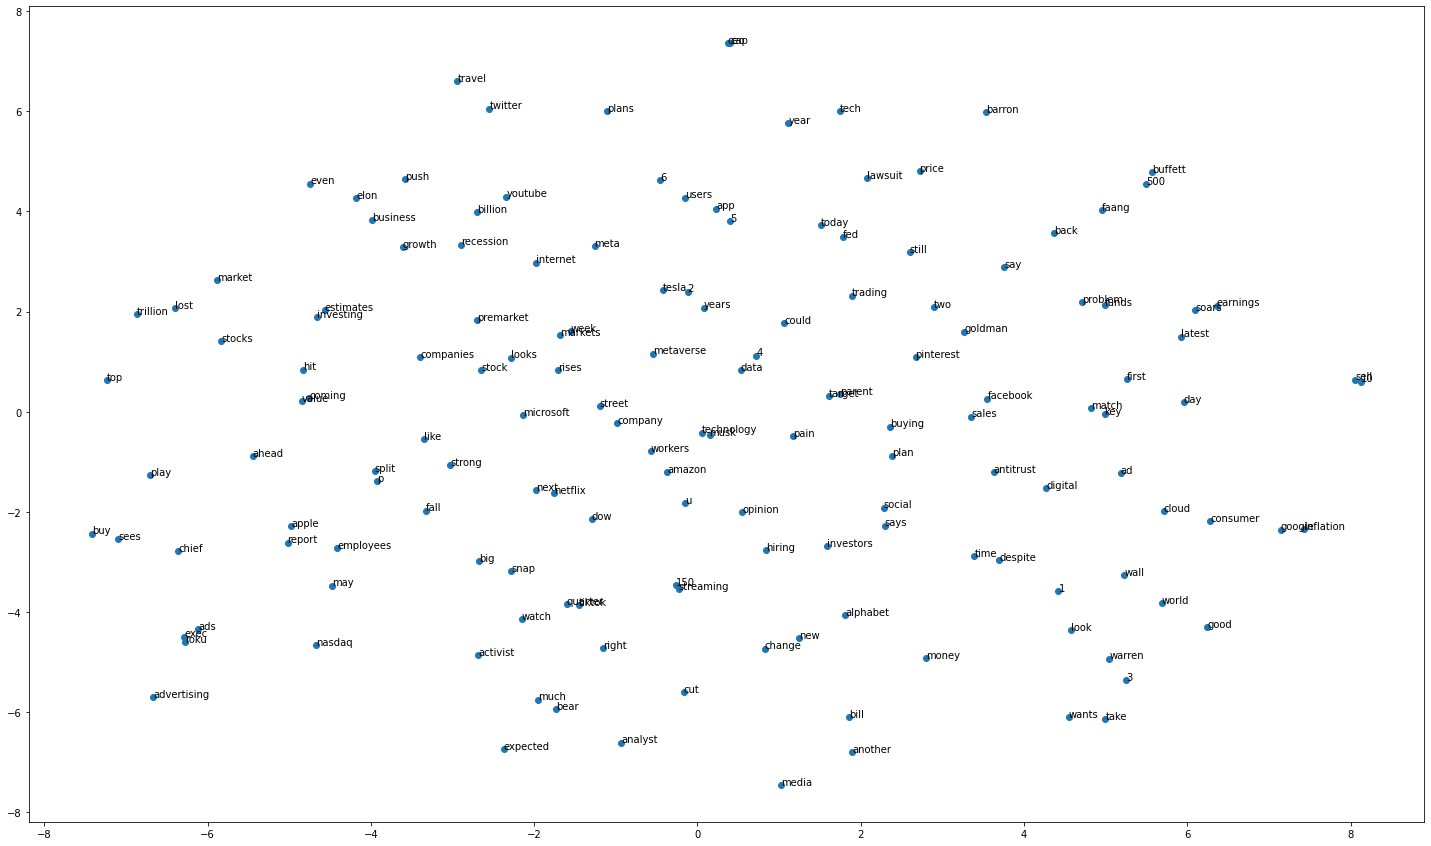

In [13]:
# Google graph
xs,ys = google_tsne[:,0], google_tsne[:,1]
plot_2d_graph(google_vocabs, xs, ys)